In [1]:
import geopandas as gpd
import laspy
from shapely.geometry import Polygon, Point
import numpy as np
import matplotlib.pyplot as plt
import copy
import shapely as shp
import open3d as o3d
import pickle
from scipy.spatial import cKDTree

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Loading data

In [2]:
# Function to load point clouds
def load_pcs(folder):
    pc_list = []

    for filename in os.listdir(folder):
        file = os.path.join(folder, filename)
        pc = laspy.read(file)
        name = filename.split(".")[0]
        pc_list.append({"name": name, "laz_file": pc})

    return pc_list

In [3]:
# Load point clouds
PCs = load_pcs("/home/azureuser/cloudfiles/code/blobfuse/sidewalk/processed_data/crossings_project/CW cleaning/PCs")

# Add additional info to point cloud dictionaries  
for pc in PCs:
    pc['xyz'] = pc['laz_file'].xyz
    pc['intensity'] = pc['laz_file'].intensity

In [4]:
# Load polygons
CW_polygons = gpd.read_file("/home/azureuser/cloudfiles/code/blobfuse/sidewalk/processed_data/crossings_project/tiles/Osdorp complete/21 output/CW_polygons_21_RD.shp")

# Down sampling point clouds

In [5]:
def cut_PC(pc):
    # Find coordinates below threshold
    indices = np.where(pc['xyz'][:, 2] < 1)
    z = pc['xyz'][:, 2]
    average_z = np.mean(z)

    # Cut intensity accordingly
    pc['PC_intensity_low'] = pc['intensity'][indices]
    pc['PC_coords_low'] = pc['xyz'][indices]

    # Compute average and std z
    z = pc['PC_coords_low'][:, 2]
    average_z = np.mean(z)
    sd_z = np.std(z)
    threshold = average_z + sd_z

    # Compute points above threshold
    indices_thres = np.where(pc['PC_coords_low'][:, 2] < threshold)
    pc['PC_intensity_std'] =  pc['PC_intensity_low'][indices_thres] 
    pc['PC_coords_std'] =  pc['PC_coords_low'][indices_thres] 

    return pc

In [6]:
for pc in PCs:
    pc = cut_PC(pc)

In [7]:
def down_sample_PC(pc, coords, intensity_str):
    xyz = pc[coords]
    intensity = pc[intensity_str]
    
    # Convert to Open3D point cloud using only XYZ
    pc_o3d = o3d.geometry.PointCloud()
    pc_o3d.points = o3d.utility.Vector3dVector(xyz)

    # Perform voxel downsampling
    downsampled_pc_o3d = pc_o3d.voxel_down_sample(0.07)

    # Retrieve downsampled XYZ points
    pc[coords + "_ds"] = np.asarray(downsampled_pc_o3d.points) 

    # Create a KDTree for the original point cloud
    tree = cKDTree(xyz)

    # For each downsampled point, find its nearest neighbor in the original cloud
    _, indices = tree.query(pc[coords + '_ds'])

    # Get indices of intensity
    pc[intensity_str + "_ds"] = intensity[indices]

    return pc


In [8]:
for pc in PCs:
    pc = down_sample_PC(pc, "PC_coords_std", "PC_intensity_std")
    print(pc['name'])
    print("all points: ", len(pc['xyz']))
    print("points after downsampling: ", len(pc['PC_coords_std_ds']))
    print("total points removed: ", len(pc['xyz']) - len(pc['PC_coords_std_ds']))
    print("----------------------------------------")

filtered_2282_9724
all points:  1795878
points after downsampling:  260598
total points removed:  1535280
----------------------------------------
filtered_2282_9725
all points:  6141444
points after downsampling:  684320
total points removed:  5457124
----------------------------------------
filtered_2283_9724
all points:  3468038
points after downsampling:  495588
total points removed:  2972450
----------------------------------------
filtered_2283_9725
all points:  6947224
points after downsampling:  630448
total points removed:  6316776
----------------------------------------


# Plotting function

In [9]:
# Function to plot CW
def plot_PC_2D(PC_pol_dict, coords, intensity):
    x = PC_pol_dict[coords][:, 0]
    y = PC_pol_dict[coords][:, 1]
    plt.figure()
    plt.scatter(x, y, c=PC_pol_dict[intensity], cmap='viridis')
    plt.colorbar(label='Reflective index')  # Add colorbar to show gradient values
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('2D with intensity gradient')
    plt.grid(True)
    plt.axis('equal')
    plt.show()

# Matching CW polygons to PCs

In [10]:
# Cut point clouds based on polygon coordinate
def PC_pol_match(PC, pol, max_heigth, pol_index):

    # Get the bounding box (rectangle) of the polygon
    minx, miny, maxx, maxy = pol.bounds
    
    # Determine condition based on polygon bounds
    condition = ((PC['PC_coords_std_ds'][:, 0] > minx) & (PC['PC_coords_std_ds'][:, 0] < maxx) 
                &  (PC['PC_coords_std_ds'][:, 1] > miny) & (PC['PC_coords_std_ds'][:, 1] < maxy) 
                & (PC['PC_coords_std_ds'][:, 2] < max_heigth))

    # Apply condition to get indices
    indexes = np.where(condition)

    # Check if any matches were found
    if len(indexes[0]) > 0:
        
        # Apply indexing to coordinates and intensity
        intensity = PC['PC_intensity_std_ds'][indexes]
        coords = PC['PC_coords_std_ds'][indexes]

        return {'polygon_index': pol_index, 'polygon': pol, 'PC_file': [PC['name']], 'PC_coords_std_ds': coords, 'PC_intensity_std_ds': intensity}
    else:
        return

In [11]:
# Function to merge polygons that are spread over two point clouds
def merge_matches(match1, match2):

    # Concatenate coordinates and intensity of both PC files belonging to the same polygon 
    coords = np.vstack((match1['PC_coords_std_ds'], (match2['PC_coords_std_ds'])))
    intensity = np.hstack((match1['PC_intensity_std_ds'], (match2['PC_intensity_std_ds'])))
    
    # Create list of PC files to add to dictionary 
    PC_list = match1['PC_file'] + match2['PC_file']
    
    # Create dictionary for matched point clouds
    new_match = {'polygon_index': match1['polygon_index'], 'polygon': match1['polygon'], 'PC_file': PC_list, 'PC_coords_std_ds': coords, 'PC_intensity_std_ds': intensity}
    
    return new_match

In [12]:
def group_matches(all_matches):
    # Create list to group together polygons that are spread over multiple point clouds
    grouped_data = []

    # Create a deep copy of the previously identified matches
    match_copy = copy.deepcopy(all_matches)

    # Loop over all matches
    for item in match_copy:

        index = item['polygon_index']

        found = False

        for sublist in grouped_data:

            # Check if the polygon is already in the list and append to the corresponding list item if this is the case
            if sublist and sublist[0]['polygon_index'] == index:
                sublist.append(item)
                found = True
                break
            
        # If the polygon is not already in the list, append it 
        if not found:
            grouped_data.append([item])
    
    return grouped_data

In [13]:
def process_grouped_matches(grouped_data):
    # Loop over the grouped polygons
    for group in grouped_data:

        # Check if there is multiple PC files for one polygon 
        if len(group) > 1:

            # Loop over each item except the last one
            for i in range(len(group) - 1):

                # Merge the first item with the next one and replace the first item 
                match = merge_matches(group[0], group[1])
                
                group[0] = match

                group.pop(1)

    # Flatten the grouped data list as each list item only has one item now
    grouped_data_flat = [item for sublist in grouped_data for item in sublist]

    return grouped_data_flat

In [14]:
def match_PC_pol(CW_polygons, PCs):

    # Create list to save all matches found
    all_matches = []

    # Loop over all polygons
    for index in range(0, len(CW_polygons)):

        # Loop over all point clouds
        for PC in PCs:

            # Check if there is a match
            match = PC_pol_match(PC, CW_polygons.loc[index][1], 2, index)
            if match:

                # Append match to match list
                all_matches.append(match)
        
    grouped_data = group_matches(all_matches)
    merged_data = process_grouped_matches(grouped_data)
    
    return merged_data, all_matches, grouped_data

In [15]:
merged_data, all_matches, grouped_data = match_PC_pol(CW_polygons, PCs)

/tmp/ipykernel_96644/3869094217.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  match = PC_pol_match(PC, CW_polygons.loc[index][1], 2, index)


# Growing polygons

In [16]:
sample = merged_data[6]
sample

{'polygon_index': 16,
 'polygon': <POLYGON ((114124.62 486256.905, 114123.21 486266.566, 114129.139 486261.569...>,
 'PC_file': ['filtered_2282_9725'],
 'PC_coords_std_ds': array([[ 1.14129039e+05,  4.86257573e+05, -7.72433099e-01],
        [ 1.14128361e+05,  4.86257306e+05, -7.59433099e-01],
        [ 1.14128417e+05,  4.86257805e+05, -7.84433099e-01],
        ...,
        [ 1.14128008e+05,  4.86260081e+05, -8.15614917e-01],
        [ 1.14123662e+05,  4.86260572e+05, -7.09210877e-01],
        [ 1.14129756e+05,  4.86260638e+05, -8.11099765e-01]]),
 'PC_intensity_std_ds': array([ 7138,  7786,  9084, ..., 12329, 27253, 11680], dtype=uint16)}

In [17]:
# Filter for intensity
def filter_intensity(cw, min_intensity):
    return_cw = copy.deepcopy(cw)

    # Determine condition based on polygon bounds
    condition = (return_cw['PC_intensity_std_ds'] > min_intensity)

    # Apply condition to get indices
    indexes = np.where(condition)

    # Check if any matches were found
    if len(indexes[0]) > 0:
        
        # Apply indexing to coordinates and intensity
        return_cw['PC_intensity_std_ds_filtered'] = return_cw['PC_intensity_std_ds'][indexes]
        return_cw['PC_coords_std_ds_filtered'] = return_cw['PC_coords_std_ds'][indexes]

    return return_cw

In [18]:
def get_wh_pol(pol):
    # get minimum bounding box around polygon
    box = pol.minimum_rotated_rectangle

    # get coordinates of polygon vertices
    x, y = box.exterior.coords.xy

    # get length of bounding box edges
    edge_length = (Point(x[0], y[0]).distance(Point(x[1], y[1])), Point(x[1], y[1]).distance(Point(x[2], y[2])))

    # get length of polygon as the longest edge of the bounding box
    length = max(edge_length)

    # get width of polygon as the shortest edge of the bounding box
    width = min(edge_length)
    
    return length, width

In [25]:
def find_cut(og_match):
    og = copy.deepcopy(og_match)    

    while True:
        #buff_size = 0.3/(shp.area(og['polygon']))

    
        # Increase size polygon
        og['pol_xl'] = og['polygon'].buffer(0.06, join_style=2)
        

        # Assert that size is not too large
        width, length = get_wh_pol(og['pol_xl'])

        if (width > 15) or (length > 15):
            print("max size reached")
            break

        # Temporary file check
        if og['PC_file'][0] == 'filtered_2283_9725':
            match = PC_pol_match(PCs[3], og['pol_xl'], 2, 13)

        else:
            match = PC_pol_match(PCs[1], og['pol_xl'], 2, 13)

        # Filter intensity
        og_filt = filter_intensity(og, 40000)
        match_filt = filter_intensity(match, 40000)

        # Transform coords in order to compare 
        og_coords = set(map(tuple, og_filt['PC_coords_std_ds']))
        match_coords = set(map(tuple, match_filt['PC_coords_std_ds']))
        

        # Get new points
        new_points = np.array(list(match_coords - og_coords))


        # Perform element-wise comparison to find indices new points
        matches = np.all(match_filt['PC_coords_std_ds'][:, None, :] == new_points, axis=2)
        indexes = np.where(matches.any(axis=1))[0]
       

        buffer = {'coords': new_points, 'intensity': match_filt['PC_intensity_std_ds'][indexes]}
        
        
        if len(og_filt['PC_intensity_std_ds_filtered']) < len(match_filt['PC_intensity_std_ds_filtered']):
            og = match
        
        else:
            break

    return og, buffer

max size reached


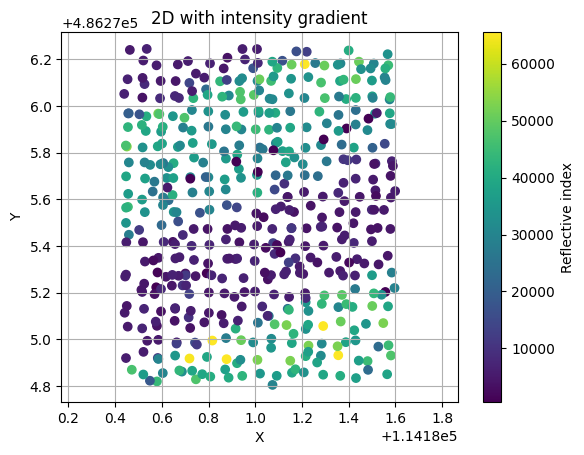

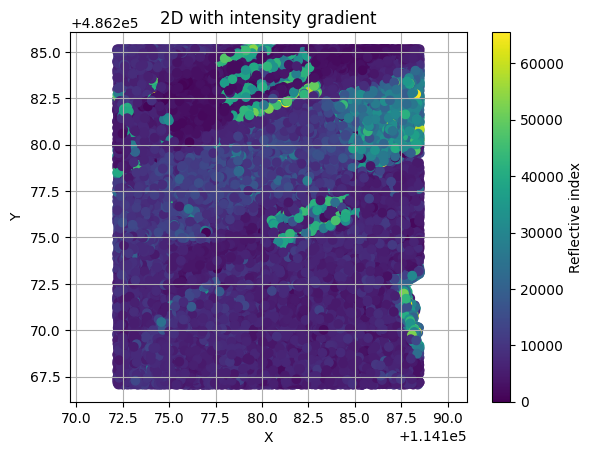

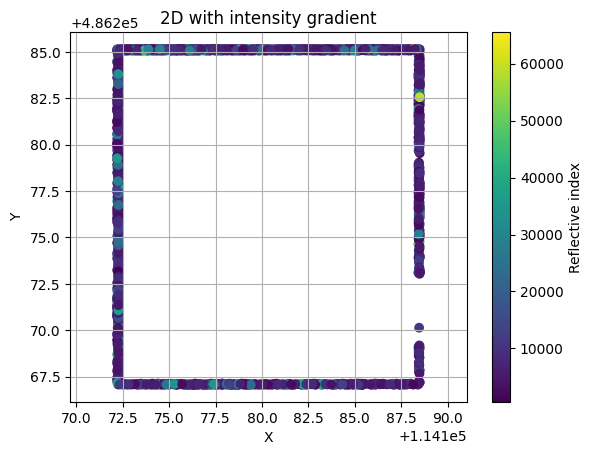

In [26]:
cut, buffer = find_cut(merged_data[8])
plot_PC_2D(merged_data[8], 'PC_coords_std_ds', 'PC_intensity_std_ds')
# plot_PC_2D(merged_data[7], 'PC_coords_std_ds', 'PC_intensity_std_ds')
# plot_PC_2D(merged_data[8], 'PC_coords_std_ds', 'PC_intensity_std_ds')
# plot_PC_2D(merged_data[10], 'PC_coords_std_ds', 'PC_intensity_std_ds')
plot_PC_2D(cut, 'PC_coords_std_ds', 'PC_intensity_std_ds')
plot_PC_2D(buffer, 'coords', 'intensity')

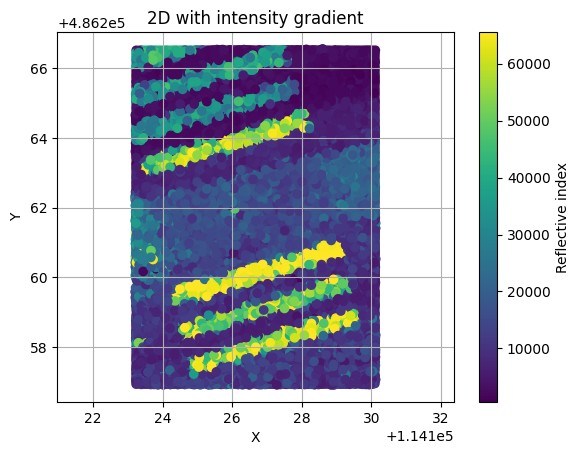

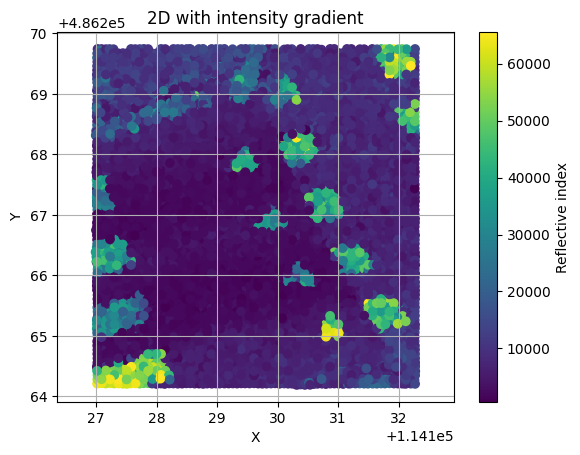

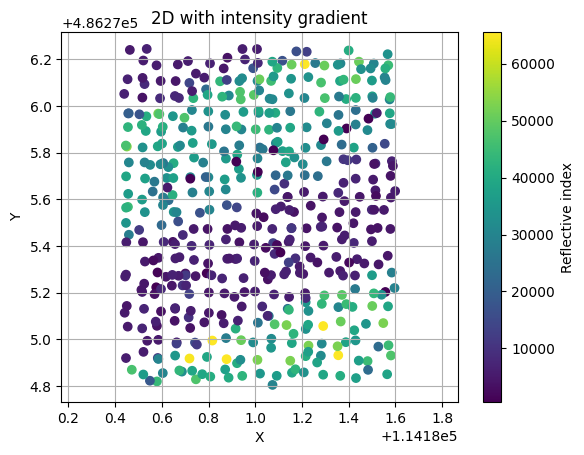

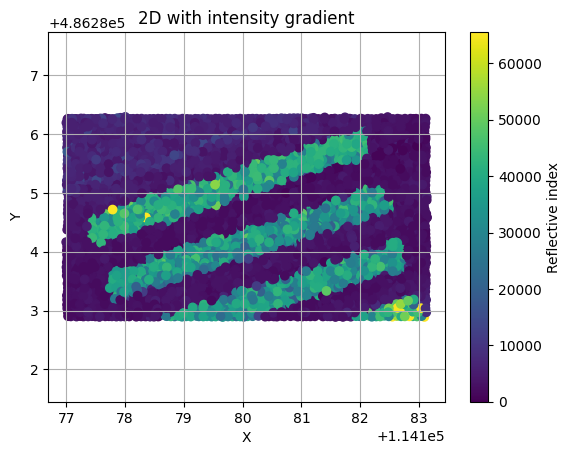

In [23]:
# cut, buffer = find_cut(merged_data[6])
plot_PC_2D(merged_data[6], 'PC_coords_std_ds', 'PC_intensity_std_ds')
plot_PC_2D(merged_data[7], 'PC_coords_std_ds', 'PC_intensity_std_ds')
plot_PC_2D(merged_data[8], 'PC_coords_std_ds', 'PC_intensity_std_ds')
plot_PC_2D(merged_data[10], 'PC_coords_std_ds', 'PC_intensity_std_ds')
# plot_PC_2D(cut, 'PC_coords_std_ds', 'PC_intensity_std_ds')
# plot_PC_2D(buffer, 'coords', 'intensity')